# Segmentation Exercise

In this exercise we will segment the left ventricle of the heart in relatively small images using neural networks. Below is the code for setting up a segmentation network and training it. The network isn't very good, so the exercise is to improve the quality of the segmentation by improving the network. 

The data being used here is derived from the Sunnybrook Dataset (https://www.cardiacatlas.org/studies/sunnybrook-cardiac-data/) of cardiac images, filtered to contain only left ventricle myocardium segmentations and reduced in XY dimensions.

First we load the data from the repo and setup libraries:

In [ ]:
%matplotlib inline

# download dataset if in Colab
![ -f scd_lvsegs_cropped.npz ] || wget https://github.com/ericspod/VPHSummerSchool2019/raw/master/scd_lvsegs_cropped.npz

import torch, torch.nn as nn, torch.nn.functional as F

import numpy as np

import matplotlib.pyplot as plt

data=np.load('scd_lvsegs_cropped.npz') # load all the data from the archive

images=data['images'] # images in BHW array order
segs=data['segs'] # segmentations in BHW array order
caseIndices=data['caseIndices'] # the indices in `images` for each case

images=images.astype(np.float32)/images.max() # normalize images

plt.imshow(images[13]+segs[13]*0.25,cmap='gray') # show image 13 with segmentation

We have only 420 images so for the sake of this exercise we will only do a division between train and test data, choosing to retain the last 6 cases as our test set. Typically you would want to have a training dataset, a validation dataset checked periodically during training to ensure the network continues to produce good results for data is isn't trained on, and a test dataset used to validate the training after the fact.

In [ ]:
testIndex=caseIndices[-6,0] # keep the last 6 cases for testing

# divide the images, segmentations, and categories into train/test sets
trainImages,trainSegs=images[:testIndex],segs[:testIndex]
testImages,testSegs=images[testIndex:],segs[testIndex:]

We define our loss function, in this case implementing the binary Dice loss based on segmentation overlap:

In [ ]:
class DiceLoss(nn.modules.loss._Loss):
    '''This defines the binary dice loss function used to assess segmentation overlap.'''
    def forward(self, source, target, smooth=1e-5):
        batchsize = target.size(0)
        source=source.sigmoid() # apply sigmoid to the source logits to impose it onto the [0,1] interval
        
        # flatten target and source arrays to 2D BV arrays
        tsum=target.view(batchsize, -1) 
        psum=source.view(batchsize, -1)
        
        intersection=psum*tsum
        sums=psum+tsum 

        # compute the score, the `smooth` value is used to smooth results and prevent divide-by-zero
        score = 2.0 * (intersection.sum(1) + smooth) / (sums.sum(1) + smooth)
        
        # `score` is 1 for perfectly identical source and target, 0 for entirely disjoint
        return 1 - score.sum() / batchsize

We now define out simple network. This doesn't do a good job so consider how to improve it by adding layers or other elements:

In [ ]:
class SegNet(nn.Sequential):
    def __init__(self):
        super().__init__(
            # layer 1: convolution, normalization, downsampling
            nn.Conv2d(1,4,3,1,1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            nn.MaxPool2d(3,2,1),
            # layer 2
            nn.Conv2d(4,8,3,1,1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            # layer 3
            nn.ConvTranspose2d(8,4,3,2,1,1),
            nn.BatchNorm2d(4),
            nn.ReLU(),
            # layer 4: output
            nn.Conv2d(4,1,3,1,1),
        )

The network is now trained. We can load the whole dataset into memory at once but typically this isn't possible. To create batches for each train step, some form of data loader is generally used which samples from existing data and sometimes applies transformations to the data before being forward passed through the network. 

5 0.9101736545562744
10 0.8976666927337646
15 0.8830223083496094
20 0.8646578788757324
25 0.8426056504249573
30 0.816073477268219
35 0.7862155437469482
40 0.7525497674942017
45 0.7190123796463013
50 0.6872385144233704
55 0.6595333814620972
60 0.6377395391464233
65 0.6213465929031372
70 0.6076920032501221
75 0.5955265760421753
80 0.5864473581314087
85 0.5773850679397583
90 0.5679671764373779
95 0.5596143007278442
100 0.5525133609771729
CPU times: user 4.06 s, sys: 412 ms, total: 4.48 s
Wall time: 4.45 s


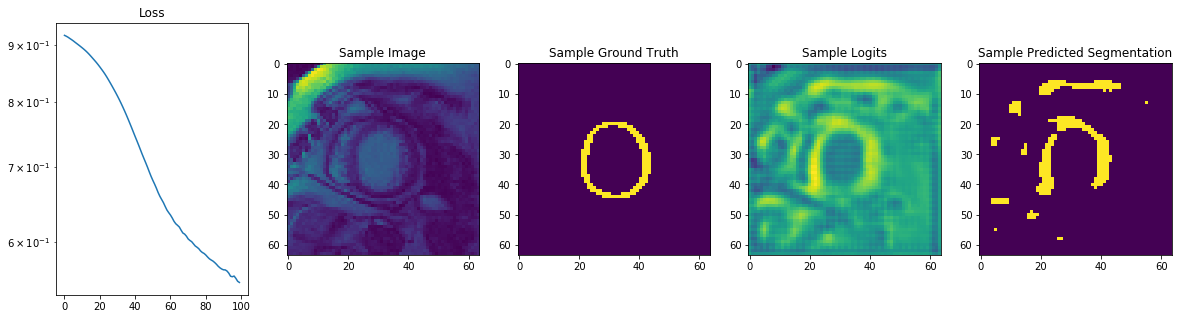

In [13]:
%%time
# store the training data as tensors
trainTensor=torch.from_numpy(trainImages[:,None])
segTensor=torch.from_numpy(trainSegs[:,None].astype(np.float32))

# create network object
net=SegNet()

# choose a device and move the net and tensors to its memory
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net=net.to(device)
trainTensor=trainTensor.to(device)
segTensor=segTensor.to(device)

# define optimizer and loss function
opt=torch.optim.Adam(net.parameters(),0.005)
loss=DiceLoss()

trainSteps=100
losses=[]

# run through training steps
for t in range(1,trainSteps+1):
    opt.zero_grad()
    net.train()
    pred=net(trainTensor)
    lossval=loss(pred,segTensor)
    lossval.backward()
    opt.step()
        
    losses.append(lossval.item())
    if t%(trainSteps//20)==0:
        print(t,lossval.item())    
    

# sample an image from the training data and look at the segmentation the network predicted for it
sample=10
predSample=pred[sample,0].cpu().data.numpy()
fig,ax=plt.subplots(1,5,figsize=(20,5))
ax[0].set_title('Loss')
ax[0].semilogy(losses)
ax[1].set_title('Sample Image')
ax[1].imshow(trainImages[10])
ax[2].set_title('Sample Ground Truth')
ax[2].imshow(trainSegs[10])
ax[3].set_title('Sample Logits')
ax[3].imshow(predSample)
ax[4].set_title('Sample Predicted Segmentation')
ax[4].imshow(predSample>0.5)

Now we apply the test data to the network. These images were never seen by the network so how well the task is performed is an indicator of how generalized and robust the network is:

Test loss: 0.6977148056030273


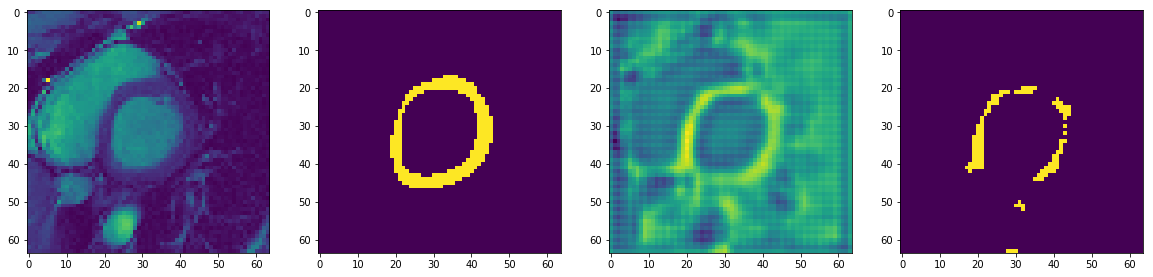

In [14]:
testTensor=torch.from_numpy(testImages[:,None]).to(device)
testSegTensor=torch.from_numpy(testSegs[:,None]).to(device).float()

net.to(device)
net.eval()
pred=net(testTensor)
testloss=loss(pred,testSegTensor).item() # calculate test loss

pred=pred.to('cpu').data.numpy()

seg=pred>0.5

fig,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(testImages[10])
ax[1].imshow(testSegs[10])
ax[2].imshow(pred[10,0])
ax[3].imshow(seg[10,0])

print('Test loss:',testloss)

The loss over the images of the test set is higher than the last loss value from training. This implies the network has become overfitted to the images it was trained with and so does a poorer job on images it hasn't seen before. What simple ways can we tackle this problem?